# tutorial 
- https://machinelearningmastery.com/lstm-for-time-series-prediction-in-pytorch/

/var/folders/58/hxkrgjd16yzcg36mh4h_qrjh0000gn/T/ipykernel_80787/386260020.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/miniforge3/conda-bld/pytorch-recipe_1673797392633/work/torch/csrc/utils/tensor_new.cpp:233.)
  return torch.tensor(X), torch.tensor(y)


Epoch 0: train RMSE 226.2008, test RMSE 425.4529
Epoch 100: train RMSE 180.0364, test RMSE 377.0674
Epoch 200: train RMSE 143.8986, test RMSE 337.6829
Epoch 300: train RMSE 113.6549, test RMSE 302.0962
Epoch 400: train RMSE 91.3878, test RMSE 271.4848
Epoch 500: train RMSE 69.4545, test RMSE 238.8985
Epoch 600: train RMSE 54.5545, test RMSE 211.1547
Epoch 700: train RMSE 43.5903, test RMSE 186.7382
Epoch 800: train RMSE 36.3292, test RMSE 165.6497
Epoch 900: train RMSE 30.9403, test RMSE 147.5016
Epoch 1000: train RMSE 27.3371, test RMSE 132.1361
Epoch 1100: train RMSE 24.9548, test RMSE 119.4023
Epoch 1200: train RMSE 23.4847, test RMSE 108.8525
Epoch 1300: train RMSE 22.5384, test RMSE 101.5248
Epoch 1400: train RMSE 21.5623, test RMSE 95.9039
Epoch 1500: train RMSE 20.9984, test RMSE 90.2426
Epoch 1600: train RMSE 20.4125, test RMSE 86.4193
Epoch 1700: train RMSE 20.4182, test RMSE 82.8945
Epoch 1800: train RMSE 19.8034, test RMSE 80.3984
Epoch 1900: train RMSE 19.9259, test RMSE 77

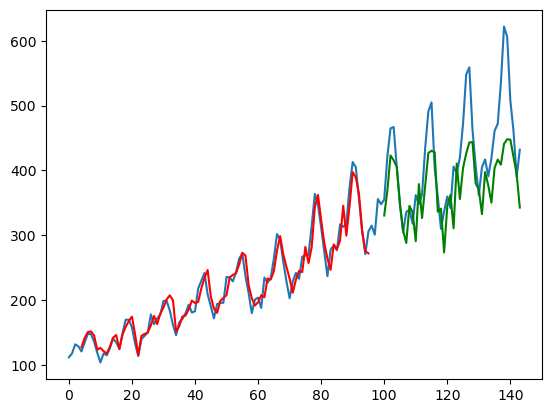

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
 
df = pd.read_csv('airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')
 
# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]
 
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)
 
lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
 
class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x
 
model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)
 
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
 
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()